# Correlation between Internet connection and response rates by county

**By Bernardo Lopez Vicencio, [NewsCounts](https://newscounts.org/)**

Due to COVID-19 pandemic the Census relies more than ever in Internet responses.

In NewsCounts we looked into the relationship between the Internet connection per county and the response rates. To do so we downloaded Internet connection data from the American Community Survey from 2018. We use the variable **B28002_002E** that refers to the population estimate with an Internet connection. For the 2020 Census response rates we used the Census Bureau API.

For each county we compared the proportion of the population with an Internet connection with the Census response rates and computed the correlation. This analysis was made for all states and for some selected states. Please contact NewsCounts team if you would like to see this results for a different state.

At the end of the notebook you can find a table with the correlation between Internet connection and response rates for each state. 

Is important to remember that correlation does not imply causation. Correlation describes a linear relationship between two variables. In the correlation is close to 1, there is a positive relationship. Correlation close to -1 is a negative relationship. And if the correlation is close to 0, there is no clear relationship between the variables.

## Results

This short analysis showed that there is a positive relationship between the Internet connection and the 2020 Census response rates. That is something to be expected because with COVID-19 pandemic the census has to rely more than ever in Internet responses. And counties with more Internet connection are more likely to be able to respond the Census.

Doing the same analysis per state we see that this relationship is very strong in some states like Arizona, Alaska, New Mexico and Maine. 

In same other states like Florida, Idaho, North Carolina and New York a relationship between Internet connections and Census response rates is not clear.

In [1]:
import json
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
states = pd.read_csv("../responseRates/Data/state_codes.csv")
counties = pd.read_csv("../responseRates/Data/county_codes.csv")

In [3]:
key = "124e1b1d5ceca3b46b3f6bd97d95ea8d4d780e28"
resp_rate_var = "CRRALL"

In [4]:
url = f"https://api.census.gov/data/2018/acs/acs1?get=B28002_002E,B01003_001E,GEO_ID&for=county:*&key={key}"
response = requests.get(url)
if response:
    print('State: Success!')
else:
    print('State: An error has occurred.')
    sys.exit("State: "+response.text)

State: Success!


In [5]:
broadband_df = pd.DataFrame.from_records(response.json()[1:])
broadband_df.columns = response.json()[0]

broadband_df

,B28002_002E,B01003_001E,GEO_ID,state,county
0,71067,218022,0500000US01003,01,003
1,34344,114277,0500000US01015,01,015
2,24503,83442,0500000US01043,01,043
3,20646,71385,0500000US01049,01,049
4,24772,81887,0500000US01051,01,051
...,...,...,...,...,...
833,36529,133191,0500000US72113,72,113
834,78990,320967,0500000US72127,72,127
835,7870,71094,0500000US72135,72,135
836,11513,74623,0500000US72137,72,137


In [6]:
url = f"https://api.census.gov/data/2020/dec/responserate?get=RESP_DATE,GEO_ID,{resp_rate_var}&for=county:*&key={key}"
response = requests.get(url)
if response:
    print('State: Success!')
else:
    print('State: An error has occurred.')
    sys.exit("State: "+response.text)

State: Success!


In [7]:
resp_rates = pd.DataFrame.from_records(response.json()[1:])
resp_rates.columns = response.json()[0]

In [8]:
broadband_df['state_county'] = broadband_df.state + broadband_df.county
broadband_df['state_county'] = broadband_df.state_county.astype(int)
broadband_df['state'] = broadband_df.state.astype(int)
broadband_df['state_name'] = broadband_df.state.map(states.set_index('code')['state'])
broadband_df['state_short'] = broadband_df.state.map(states.set_index('code')['state_code'])
broadband_df['county_name'] = broadband_df.state_county.map(counties.set_index('code')['county'])

broadband_df["response"] = broadband_df.GEO_ID.map(resp_rates.set_index("GEO_ID")[resp_rate_var])
broadband_df["response"] = broadband_df.response.astype("double")
broadband_df["internet"] = broadband_df.B28002_002E.astype("double")
broadband_df["population"] = broadband_df.B01003_001E.astype("double")
broadband_df["internetperpop"] = broadband_df.internet/broadband_df.population
broadband_df

,B28002_002E,B01003_001E,GEO_ID,state,county,state_county,state_name,state_short,county_name,response,internet,population,internetperpop
0,71067,218022,0500000US01003,1,003,1003,Alabama,AL,Baldwin,53.0,71067.0,218022.0,0.325963
1,34344,114277,0500000US01015,1,015,1015,Alabama,AL,Calhoun,60.9,34344.0,114277.0,0.300533
2,24503,83442,0500000US01043,1,043,1043,Alabama,AL,Cullman,61.4,24503.0,83442.0,0.293653
3,20646,71385,0500000US01049,1,049,1049,Alabama,AL,De Kalb,48.9,20646.0,71385.0,0.289220
4,24772,81887,0500000US01051,1,051,1051,Alabama,AL,Elmore,64.1,24772.0,81887.0,0.302514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,36529,133191,0500000US72113,72,113,72113,Puerto Rico,PR,Ponce,11.4,36529.0,133191.0,0.274260
834,78990,320967,0500000US72127,72,127,72127,Puerto Rico,PR,San Juan,12.4,78990.0,320967.0,0.246100
835,7870,71094,0500000US72135,72,135,72135,Puerto Rico,PR,Toa Alta,11.0,7870.0,71094.0,0.110699
836,11513,74623,0500000US72137,72,137,72137,Puerto Rico,PR,Toa Baja,10.5,11513.0,74623.0,0.154282


In [9]:
def get_correlation(state=None,labels=False):
    if state != None:
        df = broadband_df[broadband_df.state_short==state]
        print("State:",df.iloc[0].state_name,f"({state})\n")
    else:
        print("All states")
        df = broadband_df
    data = df[["response","internetperpop"]]
    corr=data.corr().iloc[0,1]
    print(f"Correlation between response rates and internet connection: {round(corr,4)}")
    
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    plt.scatter(df.internetperpop,df.response)
    x_range = np.arange(round(df.internetperpop.min(),2),round(df.internetperpop.max(),2)+0.01,0.01)
    plt.plot(x_range,np.poly1d(np.polyfit(df.internetperpop,df.response, 1))(x_range),c='orange')
    ax.set_xlabel("Internet per population")
    ax.set_ylabel("Response rate")
    
    if labels:
        for i in range( min(df.shape[0],200) ):
            plt.annotate(df.iloc[i].county_name, (df.iloc[i].internetperpop,df.iloc[i].response))

# All states

All states
Correlation between response rates and internet connection: 0.4666


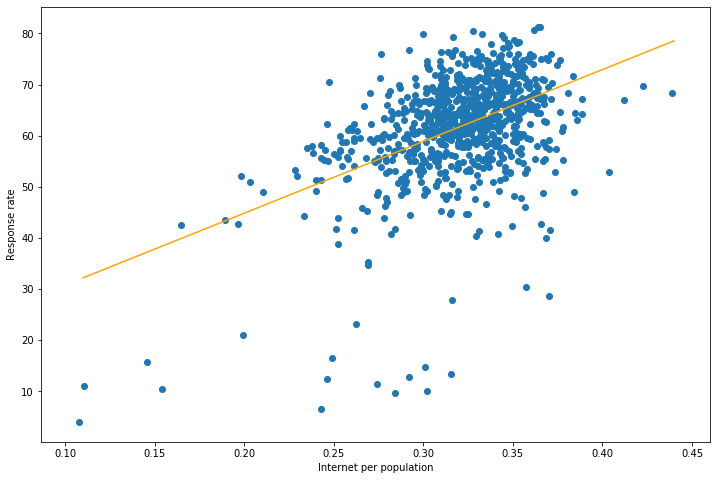

In [10]:
get_correlation()

# New York

State: New York (NY)

Correlation between response rates and internet connection: 0.0483


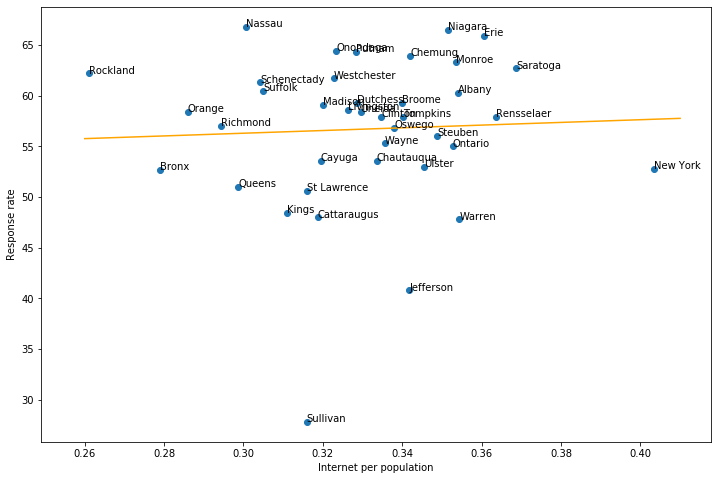

In [11]:
get_correlation("NY",True)

# Maryland

State: Maryland (MD)

Correlation between response rates and internet connection: 0.6737


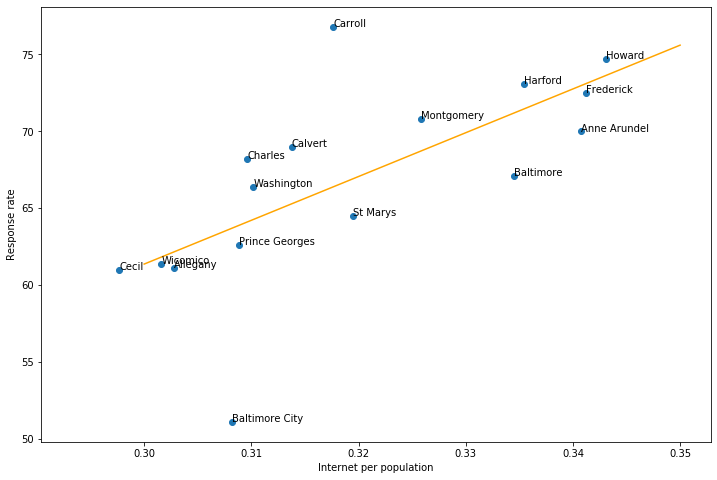

In [12]:
get_correlation("MD",True)

# New Mexico

State: New Mexico (NM)

Correlation between response rates and internet connection: 0.8406


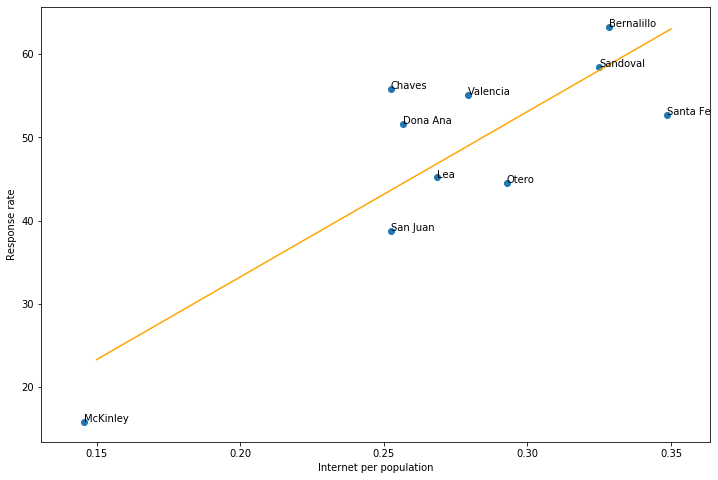

In [13]:
get_correlation("NM",True)

# Washington

State: Washington (WA)

Correlation between response rates and internet connection: 0.3731


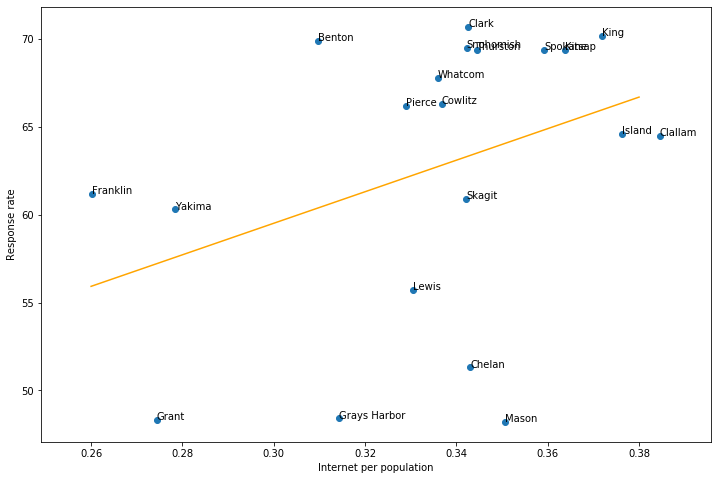

In [14]:
get_correlation("WA",True)

# Texas

State: Texas (TX)

Correlation between response rates and internet connection: 0.6045


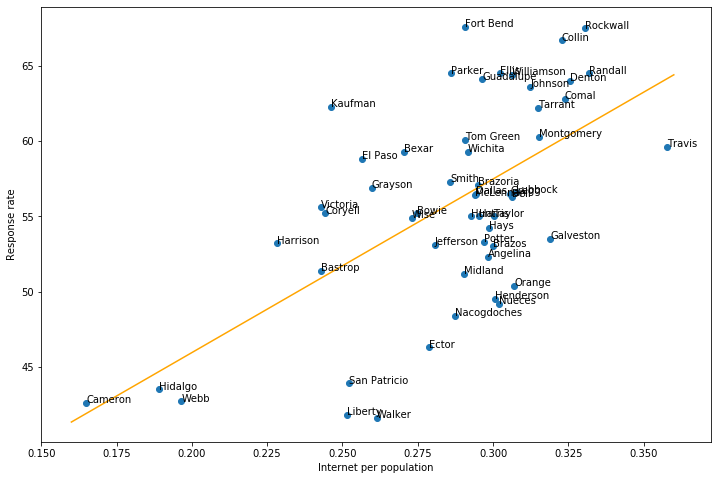

In [15]:
get_correlation("TX",True)

# Arizona

State: Arizona (AZ)

Correlation between response rates and internet connection: 0.9547


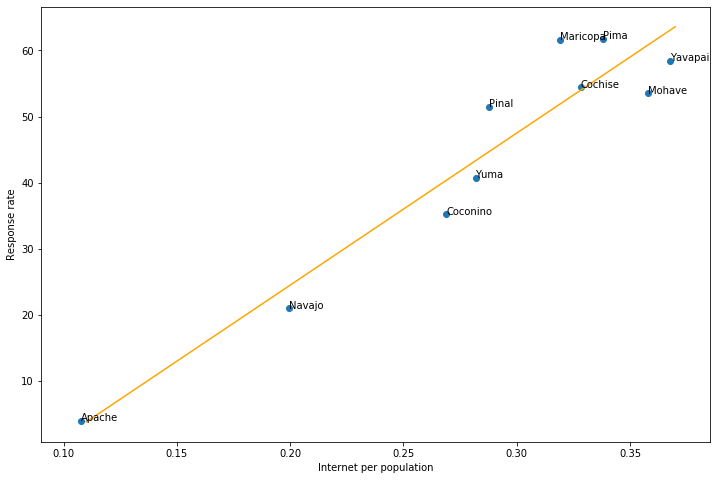

In [16]:
get_correlation("AZ",True)

In [17]:
all_states = broadband_df.state_short.unique()
correlations = []
counties_len = []
state_name = []
for s in all_states:
    df = broadband_df[broadband_df.state_short==s]
    data = df[["response","internetperpop"]]
    corr=data.corr().iloc[0,1]
    correlations.append(corr)
    counties_len.append(len(df.county.unique()))
    state_name.append(df.state_name.iloc[0])
    
df_corr = pd.DataFrame({"state":all_states, "responserates_internet_corr":correlations,
                       "counties":counties_len,"state_name":state_name})
df_corr.sort_values("responserates_internet_corr",ascending=False,inplace=True)
df_corr=df_corr[df_corr.counties>2]
df_corr[["state","state_name","responserates_internet_corr"]]

,state,state_name,responserates_internet_corr
34,ND,North Dakota,0.985036
2,AZ,Arizona,0.954743
1,AK,Alaska,0.868586
31,NM,New Mexico,0.840554
19,ME,Maine,0.741039
48,WV,West Virginia,0.675888
20,MD,Maryland,0.673683
24,MS,Mississippi,0.668593
29,NH,New Hampshire,0.668503
15,IA,Iowa,0.628084
